# Supervised learning of SNN with local rule STDP+all-LDT
# Adaptive thresholds
# Low weights = single value 
# High weights are compressed

In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.cuda as cuda
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder
from collections import Counter

from brian2 import *
import brian2.numpy_ as np

from keras.datasets import mnist

import copy
import csv
import matplotlib.pyplot as plt
from scipy import stats
import time
import pandas as pd
import operator
import random
import matplotlib.ticker as ticker
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import subprocess

import warnings
warnings.filterwarnings("ignore")

INFO       Cache size for target "cython": 2081 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/dmitry/.cython/brian_extensions" directory. [brian2]


## Data sets

In [2]:
class Transform:
    
    def __init__(self, PIL_type=False):
        self.PIL_type = PIL_type
        self.to_pil_image = transforms.ToPILImage()    
        self.to_tensor = transforms.ToTensor()
        
    def __call__(self, image):
        if self.PIL_type:
            image = self.to_pil_image(image)
        image = self.to_tensor(image)
        #image.squeeze_(0)

        return image

In [3]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [4]:
classes = [0, 1, 5] 

max_classes = 10
img_size = 28*28 # input image size

In [5]:
# number of image in each class
train_limit = 300                            
test_limit = 100

# The MNIST data was pre-divided into 10 classes
path = f'./data/MNIST_0_1_2_3_4_5_6_7_8_9/'       

for ind in classes: 
    globals()[f'train_digit_{ind}_images'] = torch.load(f'{path}train_images_{ind}.pt', 
                                                      map_location=torch.device('cpu'))[0:train_limit]
    globals()[f'train_digit_{ind}_labels'] = torch.load(f'{path}train_labels_{ind}.pt', 
                                                      map_location=torch.device('cpu'))[0:train_limit]
    globals()[f'test_digit_{ind}_images'] = torch.load(f'{path}test_images_{ind}.pt', 
                                                     map_location=torch.device('cpu'))[0:test_limit]
    globals()[f'test_digit_{ind}_labels'] = torch.load(f'{path}test_labels_{ind}.pt', 
                                                     map_location=torch.device('cpu'))[0:test_limit]

train_MNIST_labels = globals()[f'train_digit_{classes[0]}_labels']
train_MNIST_images = globals()[f'train_digit_{classes[0]}_images']
test_MNIST_labels = globals()[f'test_digit_{classes[0]}_labels']
test_MNIST_images = globals()[f'test_digit_{classes[0]}_images']                                 

for ind in classes[1:]:
    train_MNIST_labels = torch.cat((train_MNIST_labels, globals()[f'train_digit_{ind}_labels']), 0)
    train_MNIST_images = torch.cat((train_MNIST_images, globals()[f'train_digit_{ind}_images']), 0)

    test_MNIST_labels = torch.cat((test_MNIST_labels, globals()[f'test_digit_{ind}_labels']), 0)
    test_MNIST_images = torch.cat((test_MNIST_images, globals()[f'test_digit_{ind}_images']), 0)
    
# Element permutation

train_order = torch.randperm(train_MNIST_labels.shape[0])
test_order = torch.randperm(test_MNIST_labels.shape[0])

train_MNIST_labels = train_MNIST_labels[train_order].view(train_MNIST_labels.size())
train_MNIST_images = train_MNIST_images[train_order].view(train_MNIST_images.size())

test_MNIST_labels = test_MNIST_labels[test_order].view(test_MNIST_labels.size())
test_MNIST_images = test_MNIST_images[test_order].view(test_MNIST_images.size())

# decrease of pixel intensity (255 becomes ~63)

train_MNIST_images = train_MNIST_images.squeeze(1)/4
test_MNIST_images = test_MNIST_images.squeeze(1)/4

# Loaders

transform_PIL = Transform(PIL_type=True)

train_MNIST_set = CustomTensorDataset(tensors=(train_MNIST_images, train_MNIST_labels), 
                                      transform=transform_PIL)
test_MNIST_set = CustomTensorDataset(tensors=(test_MNIST_images, test_MNIST_labels), 
                                     transform=transform_PIL)

train_MNIST_loader = DataLoader(train_MNIST_set, batch_size=len(train_MNIST_set)) 
test_MNIST_loader = DataLoader(test_MNIST_set, batch_size=len(test_MNIST_set)) 

train_MNIST_images.size(), test_MNIST_images.size()

(torch.Size([900, 28, 28]), torch.Size([300, 28, 28]))

## Initial data

In [6]:
pixels_row = 28
n_input = pixels_row*pixels_row # input layer

# Setting 10 neurons per class

# common data
taupre = 20*ms
taupost = taupre

# 1-st set - Net0
n_e = 100 # e - excitatory
n_i = n_e # i - inhibitory

v_rest_e = -60.*mV # v - membrane potential
v_reset_e = -65.*mV
v_thresh_e = -52.*mV

v_rest_i = -60.*mV
v_reset_i = -45.*mV
v_thresh_i = -40.*mV

dApre = .01
dApost = -dApre * taupre / taupost * 1.05
gmax = 0.05 
dApost *= gmax
dApre *= gmax

# 2-nd set - Net1
n_ee = int(n_e/max_classes)*len(classes) # e - excitatory
n_ii = n_ee                              # i - inhibitory

vv_rest_e = -60.*mV   # v - membrane potential
vv_reset_e = -65.*mV
vv_thresh_e = -52.*mV 

vv_rest_i = -60.*mV
vv_reset_i = -45.*mV
vv_thresh_i = -40.*mV

dApre1 = .01
dApost1 = -dApre1 * taupre / taupost * 1.05
gmax1 = gmax*50   
dApost1 *= gmax1
dApre1 *= gmax1

wi = 3 # strength of inhibitory synapse in Net0
wii = 3 # strength of inhibitory synapse in Net1

# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
# stdp0, pre0, post0 for S1 
# stdp1, pre1, post1 for S4

stdp0='''w : 1
    lr : 1
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
stdp1='''w : 1
    lr1 : 1
    lr2 : 1
    dApre1/dt = -Apre1 / taupre : 1 (event-driven)
    dApost1/dt = -Apost1 / taupost : 1 (event-driven)'''

pre0='''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''
pre1='''gge += w
    Apre1 += dApre1
    w = clip(w + lr1*Apost1, 0, gmax1)'''    

post0='''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''
post1='''Apost1 += dApost1
    w = clip(w + lr2*Apre1, 0, gmax1)'''     

## Models

In [7]:
# for step 1 - training of S1

class Model0():

    def __init__(self):
        app0 = {}
        
        # input images as rate encoded Poisson generators
        app0['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')
        
        # excitatory group
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1
            '''
        app0['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', 
                                refractory=5*ms, reset='v=v_reset_e', method='euler', name='EG')
        app0['EG'].v = v_rest_e - 20.*mV       
        
        
        app0['ESP'] = SpikeMonitor(app0['EG'], name='ESP')
        app0['ERM'] = PopulationRateMonitor(app0['EG'], name='ERM')                     
        
        # ibhibitory group
        neuron_i = '''
            dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            '''
        app0['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2*ms, 
                                reset='v=v_reset_i', method='euler', name='IG')
        app0['IG'].v = v_rest_i - 20.*mV
        
        app0['ISP'] = SpikeMonitor(app0['IG'], name='ISP')
               
        # poisson generators one-to-all excitatory neurons with plastic connections 
        app0['S1'] = Synapses(app0['PG'], app0['EG'], stdp0, on_pre=pre0, on_post=post0, 
                             method='euler', name='S1') 
        app0['S1'].connect()
        app0['S1'].w = 'rand()*gmax' # random weights initialisation
        app0['S1'].lr = 1           # enable stdp    
 
        # excitatory neurons one-to-one inhibitory neurons
        app0['S2'] = Synapses(app0['EG'], app0['IG'], 'w : 1', on_pre='ge += w', name='S2')
        app0['S2'].connect(j='i')
        app0['S2'].delay = 'rand()*10*ms'
        app0['S2'].w = wi # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app0['S3'] = Synapses(app0['IG'], app0['EG'], 'w : 1', on_pre='gi += w', name='S3')
        app0['S3'].connect(condition='i!=j')
        app0['S3'].delay = 'rand()*5*ms'
        app0['S3'].w = wi/n_e # weights are selected in such a way as to maintain a balance between excitation and ibhibition

        self.net0 = Network(app0.values())
        self.net0.run(0*second)

    def __getitem__(self, key):
        return self.net[key]

    def train(self, X, targets, epochs=1):
       
        # enable stdp 
        self.net0['S1'].lr = 1         
        
        for ep in range(epochs):
            
            for idx in range(len(X)):
                yt = int(targets[idx]) # target class
         
                # active mode
                self.net0['PG'].rates = X[idx].ravel()*Hz
                self.net0.run(0.35*second)

                # passive mode
                self.net0['PG'].rates = np.zeros(n_input)*Hz
                self.net0.run(0.15*second)

In [8]:
# Model0 activation
model_previous = Model0()

# model0 from file "Preliminary_Model"
model_previous.net0.restore('model0','saved_model0.b2')

In [11]:
class Model():

    def __init__(self):
        app = {}
        
        # NEURON LAYERS
        # input images as rate encoded Poisson generators
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')
        
        app['PSP'] = SpikeMonitor(app['PG'], name='PSP')
        app['PRM'] = PopulationRateMonitor(app['PG'], name='PRM')     
        
        # first excitatory group (WITHOUT ADAPTIVE THRESHOLD)
        neuron_e = '''
                    dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
                    dge/dt = -ge / (5*ms) : 1
                    dgi/dt = -gi / (10*ms) : 1
                    '''    
        
        app['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', 
                                refractory=5*ms, reset='v=v_reset_e', method='euler', name='EG')
        app['EG'].v = v_rest_e - 20.*mV       
                
        app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
        app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
        app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')                     
        
        # first inhibitory group
        neuron_i = '''
                    dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
                    dge/dt = -ge / (5*ms) : 1
                    '''
        app['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2*ms, 
                                reset='v=v_reset_i', method='euler', name='IG')
        app['IG'].v = v_rest_i - 20.*mV
        
        app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
        app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
        app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')
        
        # second excitatory group (WITH ADAPTIVE THRESHOLD)
        neuron_ee = '''
                    dvv/dt = (gge*(0*mV-vv) + ggi*(-100*mV-vv) + (vv_rest_e-vv)) / (100*ms) : volt
                    dgge/dt = -gge / (5*ms) : 1
                    dggi/dt = -ggi / (10*ms) : 1
                    dvvt/dt = (vv_thresh_e-vvt)/(350*ms) : volt
                    vv2 : volt
                    '''        
        reset_ee = '''
                    vv = vv_reset_e
                    vvt += 3*mV
                    '''              
        
        app['EEG'] = NeuronGroup(n_ee, neuron_ee, threshold='vv>vv2', 
                                refractory=5*ms, reset=reset_ee, 
                                method='euler', name='EEG')
        
        for cl in range(len(classes)):           
            app[f'EEG_{cl}'] = Subgroup(app['EEG'], cl*10, (cl+1)*10, name=f'EEG_{cl}')
            app[f'EEG_{cl}'].vv = vv_rest_e - 20.*mV     
            app[f'EEG_{cl}'].vvt = vv_thresh_e   
            app[f'EEG_{cl}'].vv2 = vv_thresh_e
              
        for cl in range(len(classes)):
            app[f'EESM_{cl}'] = StateMonitor(app[f'EEG_{cl}'], ['vv', 'vvt'], record=True, name=f'EESM_{cl}')
            app[f'EESP_{cl}'] = SpikeMonitor(app[f'EEG_{cl}'], name=f'EESP_{cl}')
            app[f'EERM_{cl}'] = PopulationRateMonitor(app[f'EEG_{cl}'], name=f'EERM_{cl}')
        

        # second ibhibitory group
        neuron_ii = '''
                    dvv/dt = (gge*(0*mV-vv) + (vv_rest_i-vv)) / (10*ms) : volt
                    dgge/dt = -gge / (5*ms) : 1
                    '''
        app['IIG'] = NeuronGroup(n_ii, neuron_ii, threshold='vv>vv_thresh_i', 
                                refractory=2*ms, reset='vv=vv_reset_i', 
                                method='euler', name='IIG')
        app['IIG'].vv = vv_rest_i - 20.*mV

        app['IISP'] = SpikeMonitor(app['IIG'], name='IISP')
        app['IISM'] = StateMonitor(app['IIG'], ['vv'], record=True, name='IISM')
        app['IIRM'] = PopulationRateMonitor(app['IIG'], name='IIRM')

        # SYNAPSES
        # poisson generators one-to-all excitatory neurons with plastic connections 
        app['S1'] = Synapses(app['PG'], app['EG'], stdp0, on_pre=pre0, on_post=post0, 
                             method='euler', name='S1') 
        app['S1'].connect()        
        app['S1'].w = model_previous.net0['S1'].w  # weights from trained model       
        app['S1'].lr = 0                           # disable stdp    
 
        # excitatory neurons one-to-one inhibitory neurons
        app['S2'] = Synapses(app['EG'], app['IG'], 'w : 1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = wi # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app['S3'] = Synapses(app['IG'], app['EG'], 'w : 1', on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app['S3'].w = wi/n_e # weights are selected in such a way as to maintain a balance between excitation and ibhibition

        # first excitatory neurons one-to-all second excitatory neurons with plastic connections
        for cl in range(len(classes)):
            # we should have a possibility to independently change learning rate for every class subgroup
            app[f'S4_{cl}'] = Synapses(app['EG'], app['EEG'][cl*10:(cl+1)*10], stdp1, on_pre=pre1,\
                                       on_post=post1, method='euler', name=f'S4_{cl}')
            app[f'S4_{cl}'].connect()            
            app[f'S4_{cl}'].w = 'rand()*gmax1' # random weights initialisation
            app[f'S4_{cl}'].lr1 = 1           # enable stdp
            app[f'S4_{cl}'].lr2 = 1           # enable stdp
            
        # excitatory neurons one-to-one inhibitory neurons
        app['S5'] = Synapses(app['EEG'], app['IIG'], 'w : 1', on_pre='gge += w', name='S5')
        app['S5'].connect(j='i')
        app['S5'].delay = 'rand()*10*ms'
        app['S5'].w = wii # multiply by 3

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app['S6'] = Synapses(app['IIG'], app['EEG'], 'w : 1', on_pre='ggi += w', name='S6')
        app['S6'].connect(condition='i!=j')
        app['S6'].delay = 'rand()*5*ms'
        app['S6'].w = wii/n_ee 
                
        self.net = Network(app.values())
        self.net.run(0*second)

    def __getitem__(self, key):
        return self.net[key]

    def train(self, data, targets, epochs=1):
       
        # enable stdp 
        self.net['S1'].lr = 1         
        
        for ep in range(epochs):
            
            for idx in range(len(data)):
                yt = int(targets[idx]) # target class
         
                # active mode
                self.net['PG'].rates = data[idx].ravel()*Hz               
                self.net.run(0.35*second)

                # passive mode
                self.net['PG'].rates = np.zeros(n_input)*Hz
                self.net.run(0.15*second)
        
    def train_supervised(self, data, targets):        

        # disable stdp 
        self.net['S1'].lr = 0 
        
        # ratios for calculation of adaptive threshold's values
        coeff = [1.0, 1.0, 1.0]
        
        vvt_classes = [[(vv_thresh_e/mV)*coeff[i]]*int(n_e/max_classes) for i in arange(len(classes))]
        
        for idx in range(len(data)):
            
            yt = int(targets[idx])             # target class    
            
            # only for adaptive threshold !!!
            if idx==0:
                for cl in range(len(classes)):           
                    self.net[f'EEG_{cl}'].vv2 = 'vvt'                
            else:  
                for cl in range(len(classes)):
                    self.net[f'EEG_{cl}'].vv2 = vvt_classes[cl]*mV

            # set learning rate for each subgroup of excitatory neurons
            for cl in range(len(classes)): 
                
                # Learning rate (lr1, lr2) values for S4
                if cl == classes.index(yt):  
                    self.net[f'S4_{cl}'].lr1 = 1  # canonical STDP
                    self.net[f'S4_{cl}'].lr2 = 1
                else:
                    self.net[f'S4_{cl}'].lr1 = 1  # all-LTD 
                    self.net[f'S4_{cl}'].lr2 = -1
            
            # active mode 
            self.net['PG'].rates = data[idx].ravel()*Hz 
            self.net.run(0.35*second)

            # passive mode         
            self.net['PG'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)      
            
            vvt_classes[classes.index(yt)] = list(self.net[f'EEG_{classes.index(yt)}'].vvt/mV)
                        
        return vvt_classes  
            
    def evaluate(self, data, targets):
     
        self.net['S1'].lr = 0  
        
        # remembering the original weights to substitute at the end
        for cl in range(len(classes)):
            globals()[f'initial_weights_{cl}'] = copy.deepcopy(np.array(self.net[f'S4_{cl}'].w))
       
        for cl in range(len(classes)):                           # for adaptive threshold 
            self.net[f'EEG_{cl}'].vv2 = vv_thresh_e

        for cl in range(len(classes)):
            self.net[f'S4_{cl}'].lr1 = 0  # turn off learning
            self.net[f'S4_{cl}'].lr2 = 0  # turn off learning

        cols = [[f'weight_{i}' for i in range(len(classes))], \
                [f'upper_i_{i}' for i in range(len(classes))], \
                [f'lower_i_{i}' for i in range(len(classes))], \
                [f'new_weight_{i}' for i in range(len(classes))], \
                [f'new_new_weight_{i}' for i in range(len(classes))], \
                [f'new_upper_i_{i}' for i in range(len(classes))], \
                [f'new_lower_i_{i}' for i in range(len(classes))]]
        cols = [item for elem in cols for item in elem]      
        weight_set = pd.DataFrame(0, index=np.arange(len(self.net['S4_0'].w)), columns=cols)  
        
        maximum_upper_weight_set = []
        minimum_upper_weight_set = []
        maximum_lower_weight_set = []
        
        point_array = []        
        
        upper_value_sum_list = []
        upper_number_list = []       
        
        lower_value_sum_list = []
        lower_number_list = [] 

        # initial weight division 
        
        for cl in range(len(classes)): 
            
            initial_array = list(self.net[f'S4_{cl}'].w)
            initial_array = np.array(copy.deepcopy(initial_array))
            initial_series = pd.Series(initial_array)

            ratio = 0.01 # ratio of the elementary weights segment's length for the derivative calculation
            number_of_split = int(ratio*len(initial_array))
            weight_lin = np.linspace(-1, 3, number_of_split)
            
            # calculation of the second derivative curve
            KDE = stats.gaussian_kde(initial_series)
            pdf_weights = KDE.pdf(weight_lin)
            first_derivative = np.gradient(pdf_weights)
            second_derivative = np.gradient(first_derivative)
            last_negative = 0
            first_positive = 1
            for i in range(len(second_derivative)):
                if second_derivative[i]<=0 and second_derivative[i+1]>=0:
                    last_negative = i
                    first_positive = i + 1
                    break
            #inflection point of the second derivative curve
            point = (weight_lin[last_negative] + weight_lin[first_positive])/2  
            point_array.append(point)
            
            weight_set[f'weight_{cl}'] = initial_series
            weight_set[f'upper_i_{cl}'].loc[weight_set[f'weight_{cl}']>=point] = 1
            weight_set[f'lower_i_{cl}'].loc[weight_set[f'weight_{cl}']<point] = 1        

            upper_weights = weight_set[f'weight_{cl}'].loc[weight_set[f'upper_i_{cl}']==1] 
            lower_weights = weight_set[f'weight_{cl}'].loc[weight_set[f'lower_i_{cl}']==1]

            upper_value_sum_list.append(sum(upper_weights))
            upper_number_list.append(sum(weight_set[f'upper_i_{cl}']))
            
            lower_value_sum_list.append(sum(lower_weights))
            lower_number_list.append(sum(weight_set[f'lower_i_{cl}']))

            # weight's boundaries
            if len(weight_set[f'weight_{cl}'].loc[weight_set[f'lower_i_{cl}']==1])==0:
                temp_max_lower = 0
            else:
                temp_max_lower = max(weight_set[f'weight_{cl}'].loc[weight_set[f'lower_i_{cl}']==1])                
            maximum_lower_weight_set.append(temp_max_lower)
                
            if len(weight_set[f'weight_{cl}'].loc[weight_set[f'upper_i_{cl}']==1])==0:
                temp_max_upper = maximum_lower_weight
            else:
                temp_max_upper = max(weight_set[f'weight_{cl}'].loc[weight_set[f'upper_i_{cl}']==1])            
            maximum_upper_weight_set.append(temp_max_upper)

            if len(weight_set[f'weight_{cl}'].loc[weight_set[f'upper_i_{cl}']==1])==0:
                temp_min_upper = maximum_lower_weight
            else:
                temp_min_upper = min(weight_set[f'weight_{cl}'].loc[weight_set[f'upper_i_{cl}']==1])            
            minimum_upper_weight_set.append(temp_min_upper)     
            
        # target selection
        for i in range(len(classes)): 
            if upper_value_sum_list[i] == max(upper_value_sum_list):
                target_element = i
                
        maximum_lower_weight = max(maximum_lower_weight_set)
        minimum_lower_weight = 0 
        maximum_upper_weight = max(maximum_upper_weight_set) # gmax1
        minimum_upper_weight = max(minimum_upper_weight_set)        
        
        new_point = (minimum_upper_weight + maximum_lower_weight)/2 # new common weight border (for all classes)
        lower_median = median(weight_set[f'weight_{target_element}'].loc[weight_set[f'lower_i_{target_element}']==1])
        
        max_upper_value_sum = max(upper_value_sum_list) # target sum for all high weight segments
        max_upper_number = max(upper_number_list) # target number of high weight synapses for all segments
        
        max_lower_value_sum = lower_value_sum_list[target_element] # target sum for all low weight segments
        max_lower_number = lower_number_list[target_element] # target number of low weight synapses for all segments        
       
        initial_weight_set = copy.deepcopy(weight_set) # out of curiosity
                
        # secondary weight division
         
        for cl in range(len(classes)): 
            initial_array = list(self.net[f'S4_{cl}'].w)
            initial_array = np.array(copy.deepcopy(initial_array))
            finite_tensor = torch.zeros(len(self.net['S4_0'].w), dtype=torch.float64)
            
            # the upper weights SHIFT until the weight's sum matches

            # preliminary increasing the number of upper weights
            temp_weight_set = weight_set.sort_values(f'weight_{cl}', ascending=False)
            new_upper_indexes = copy.deepcopy(temp_weight_set[f'weight_{cl}'][:max_upper_number].index)
            weight_set[f'new_upper_i_{cl}'].loc[weight_set.index.isin(new_upper_indexes)] = 1 
            weight_set[f'new_lower_i_{cl}'].loc[weight_set[f'new_upper_i_{cl}']==0] = 1
            del temp_weight_set

            #-----------------------------------------------------
            # UPPER weight's segment creating (WEIGHT COMPRESSION)            
            temp_max_upper = max(weight_set[f'weight_{cl}'].loc[weight_set[f'new_upper_i_{cl}']==1])
            temp_min_upper = min(weight_set[f'weight_{cl}'].loc[weight_set[f'new_upper_i_{cl}']==1])
            initial_delta_upper_weight = temp_max_upper - temp_min_upper

            # delta of weights in new high weight segment
            upper_value_sum = sum(weight_set[f'weight_{cl}'].loc[weight_set[f'new_upper_i_{cl}']==1])
            
            # gmax1 as max value
            quotient_up = max_upper_value_sum - gmax1 * max_upper_number   
            divisor_up = upper_value_sum - gmax1 * max_upper_number 

            # multiplier for weight compression
            multiplier_up = quotient_up/divisor_up

            # free term for weight compression
            # gmax1 as max value
            free_term_up = gmax1 * (1 - multiplier_up) 

            # upper weights compression        
            weight_set[f'new_weight_{cl}'].loc[weight_set[f'new_upper_i_{cl}']==1] = \
               free_term_up + weight_set[f'weight_{cl}'].loc[weight_set[f'new_upper_i_{cl}']==1]*multiplier_up

            upper_weights = np.clip(np.array(weight_set[f'new_weight_{cl}'].loc[weight_set[f'new_upper_i_{cl}']==1]), minimum_upper_weight, gmax1)
            upper_indexes = weight_set[weight_set[f'new_upper_i_{cl}']==1].index 

            upper_weights_t = torch.tensor(upper_weights)
            upper_weights_tensor = upper_weights_t.clone().detach()
            upper_indexes_t = torch.tensor(upper_indexes, dtype=torch.int64)
            upper_indexes_tensor = upper_indexes_t.clone().detach()

            finite_tensor.scatter_(0, upper_indexes_tensor, upper_weights_tensor)   
            finite_tensor = finite_tensor.clone().detach()       
            
            #-----------------------------------------------------
            # LOWER weight's segment - JUST ONE VALUE = 0.15 * maximum_lower_weight
            
            weight_set[f'new_weight_{cl}'].where(weight_set[f'new_weight_{cl}']>=maximum_lower_weight, \
                                             0.15 * maximum_lower_weight, inplace=True)
            
            lower_weights = np.clip(np.array(weight_set[f'new_weight_{cl}'].loc[weight_set[f'new_lower_i_{cl}']==1]), minimum_lower_weight, maximum_lower_weight)
            lower_indexes = weight_set[weight_set[f'new_lower_i_{cl}']==1].index 

            lower_weights_t = torch.tensor(lower_weights)
            lower_weights_tensor = lower_weights_t.clone().detach()
            lower_indexes_t = torch.tensor(lower_indexes, dtype=torch.int64)
            lower_indexes_tensor = lower_indexes_t.clone().detach()
            
            finite_tensor.scatter_(0, lower_indexes_tensor, lower_weights_tensor)       

            finite_data = finite_tensor.detach().numpy()
            
            weight_set[f'new_weight_{cl}'] = pd.Series(finite_data)
                           
            # final substitution
            self.net[f'S4_{cl}'].w = finite_data 
            
        cc = 0 # number of correct classifications
        uncc = 0
        without_spikes = 0
        true_class_counts = np.zeros(len(classes))
        false_class_counts = np.zeros(len(classes))

        for idx in range(len(data)):   
                    
            yt = int(targets[idx])     # target class  

            # rate monitor to count spikes
            mon = SpikeMonitor(self.net['EEG'], record=True, name='RRM')
            self.net.add(mon)

            # active mode               
            self.net['PG'].rates = data[idx].ravel()*Hz 
            self.net.run(0.35*second)

            # passive mode
            self.net['PG'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)            

            counts = [] # spike counts for every group
            # calculate spike count for every group of excitatory neurons            
            for cl in range(len(classes)):                                
                counts.append(sum(mon.count[cl*10:(cl+1)*10]))      

            
            if len(self.net['RRM'].i) > 0:                
                if counts.index(max(counts)) == classes.index(yt): # check the correctness of prediction
                    cc += 1  
                    true_class_counts[classes.index(yt)] += 1
                else:
                    uncc += 1
                    false_class_counts[classes.index(yt)] += 1
                    
            else:
                without_spikes += 1
                
            self.net.remove(self.net['RRM']) # delete monitor to free up memory 

        return cc/len(data), uncc/len(data), without_spikes/len(data), true_class_counts, \
                    false_class_counts, initial_weight_set, weight_set, point_array, new_point

## Model activation

In [12]:
model = Model()

model.net.restore("model",'model.b2')

## Training of S4

## Initial weight set chart

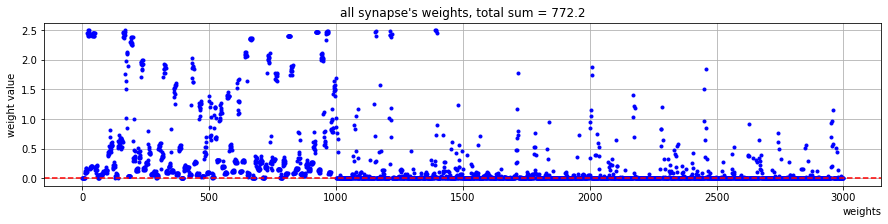

In [13]:
weights = np.concatenate((np.array(model.net['S4_0'].w), \
                          np.array(model.net['S4_1'].w), np.array(model.net['S4_2'].w)), axis=0)
plot_weights(weights, 0, f"all synapse's weights, total sum = {sum(weights) :.1f}")

## Estimation + weight set modernization

In [14]:
start_0 = time.time()
    
start = time.time()

for data, targets in test_MNIST_loader:     

    data = data.squeeze(1)
    targets = np.array(targets.numpy(), dtype=uint8)

    for i in range(len(data)):   
        data_n = data[i].numpy().ravel()*256
        if i == 0:
            data_np = data_n
        else:
            data_np = np.vstack((data_np, data_n))  

    correct, wrong, unrecognized, true_class_counts, false_class_counts, initial_weight_set, \
        weight_set, point_array, new_point = model.evaluate(data_np, targets)

end = time.time()
print(f'Processing time: {int((end - start)//60)} min {int((end - start)%60)} sec')
print('--'*30)  
print(f'Accuracy {correct*100 :.1f}%, wrong recognized {wrong*100 :.1f}%, unrecognized {unrecognized*100 :.1f}%')
for i in range(len(classes)):
    print(f'    class {i}: correctly - {true_class_counts[i]}, incorrectly - {false_class_counts[i]}')
print('--'*30)
end_0 = time.time()

Processing time: 19 min 9 sec
------------------------------------------------------------
Accuracy 72.0%, wrong recognized 28.0%, unrecognized 0.0%
    class 0: correctly - 99.0, incorrectly - 1.0
    class 1: correctly - 95.0, incorrectly - 5.0
    class 2: correctly - 22.0, incorrectly - 78.0
------------------------------------------------------------


## Final weight set chart

In [15]:
wts = np.concatenate((np.array(model.net['S4_0'].w), \
                      np.array(model.net['S4_1'].w), np.array(model.net['S4_2'].w)), axis=0)

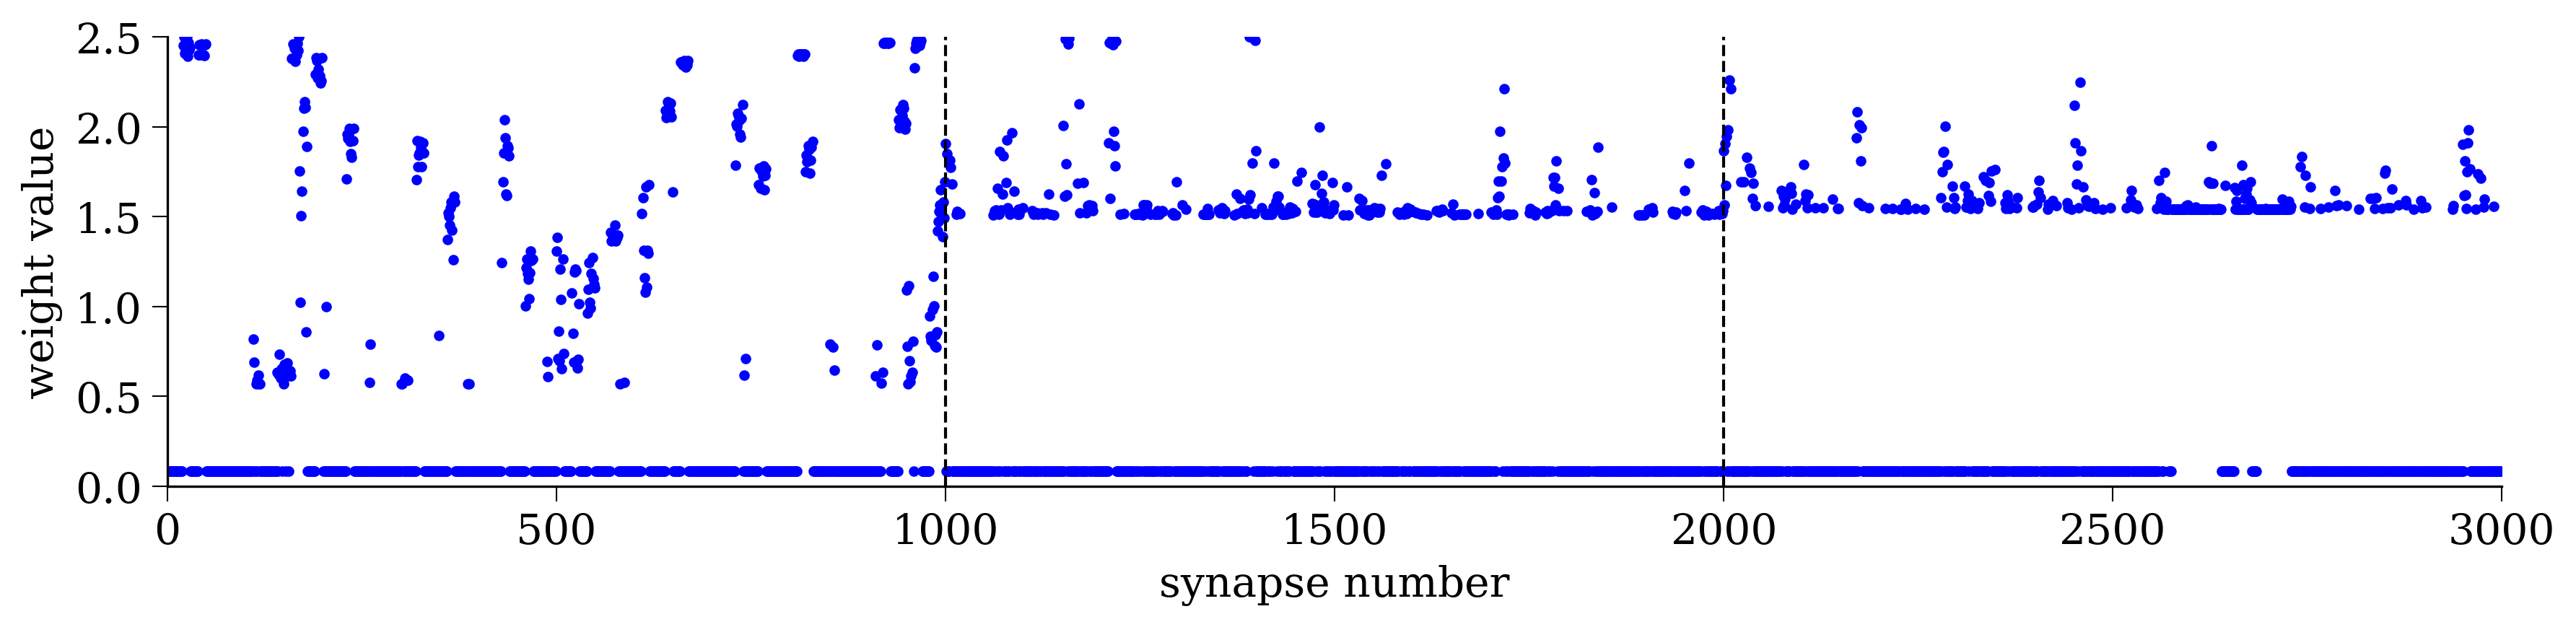

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=300, constrained_layout=True) 

fig.set_figheight(3)
fig.set_figwidth(12)

ax.set_xlim(left=0.0, right=3000.0)
ax.set_ylim(bottom=0, top=2.5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

ax.set_xlabel(r"synapse number", loc='center', fontsize=14, fontfamily='serif')
ax.set_ylabel(r'weight value',  loc='center', fontsize=14, fontfamily='serif')

ax.xaxis.set_tick_params(which='major', size=5, width=0.5, labelsize = 14, direction='out')
ax.yaxis.set_tick_params(which='major', size=5, width=0.5, labelsize = 14, direction='out')

ax.set_yticklabels([0, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5], fontsize=14, family="serif");  
ax.set_xticklabels([0, 0, 500, 1000, 1500, 2000, 2500, 3000], fontsize=14, family="serif"); 

ax.plot(np.arange(len(wts)), wts, '.b', markersize=5, marker = '.');

ax.axvline(1000, color='black', linestyle='--', linewidth=1);
ax.axvline(2000, color='black', linestyle='--', linewidth=1);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.set(facecolor='w')

fig.tight_layout()